In [2]:
# Exploratory Data Analysis
import pandas as pd
data = pd.read_csv('TMDb_updated.CSV')

data_info = data.info()
data_head = data.head()
data_description = data.describe(include='all')

data_info, data_head, data_description

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         10000 non-null  int64  
 1   title              10000 non-null  object 
 2   overview           9970 non-null   object 
 3   original_language  10000 non-null  object 
 4   vote_count         10000 non-null  int64  
 5   vote_average       10000 non-null  float64
dtypes: float64(1), int64(2), object(3)
memory usage: 468.9+ KB


(None,
    Unnamed: 0                           title  \
 0           0                        Ad Astra   
 1           1                       Bloodshot   
 2           2               Bad Boys for Life   
 3           3                         Ant-Man   
 4           4  Percy Jackson: Sea of Monsters   
 
                                             overview original_language  \
 0  The near future, a time when both hope and har...                en   
 1  After he and his wife are murdered, marine Ray...                en   
 2  Marcus and Mike are forced to confront new thr...                en   
 3  Armed with the astonishing ability to shrink i...                en   
 4  In their quest to confront the ultimate evil, ...                en   
 
    vote_count  vote_average  
 0        2853           5.9  
 1        1349           7.2  
 2        2530           7.1  
 3       13611           7.1  
 4        3542           5.9  ,
          Unnamed: 0    title       overview origina

In [3]:
# Data Cleaning
data_cleaned = data.drop(columns=['Unnamed: 0'])

missing_overviews = data_cleaned['overview'].isnull().sum()
data_cleaned = data_cleaned.dropna(subset=['overview'])

initial_count = len(data_cleaned)
data_cleaned = data_cleaned.drop_duplicates(subset=['title'], keep='first')
duplicates_removed = initial_count - len(data_cleaned)

data_cleaned_info = data_cleaned.info()
data_cleaned_head = data_cleaned.head()
missing_overviews, duplicates_removed, data_cleaned_info, data_cleaned_head

<class 'pandas.core.frame.DataFrame'>
Index: 9659 entries, 0 to 9999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   title              9659 non-null   object 
 1   overview           9659 non-null   object 
 2   original_language  9659 non-null   object 
 3   vote_count         9659 non-null   int64  
 4   vote_average       9659 non-null   float64
dtypes: float64(1), int64(1), object(3)
memory usage: 452.8+ KB


(30,
 311,
 None,
                             title  \
 0                        Ad Astra   
 1                       Bloodshot   
 2               Bad Boys for Life   
 3                         Ant-Man   
 4  Percy Jackson: Sea of Monsters   
 
                                             overview original_language  \
 0  The near future, a time when both hope and har...                en   
 1  After he and his wife are murdered, marine Ray...                en   
 2  Marcus and Mike are forced to confront new thr...                en   
 3  Armed with the astonishing ability to shrink i...                en   
 4  In their quest to confront the ultimate evil, ...                en   
 
    vote_count  vote_average  
 0        2853           5.9  
 1        1349           7.2  
 2        2530           7.1  
 3       13611           7.1  
 4        3542           5.9  )

In [7]:
import numpy as np
data_cleaned.replace([np.inf, -np.inf], np.nan, inplace=True)
data_cleaned.describe()

,vote_count,vote_average
count,9659.000000,9659.000000
mean,1032.045967,6.314826
std,2011.481471,1.333581
min,0.000000,0.000000
25%,144.000000,5.800000
50%,336.000000,6.500000
75%,934.500000,7.100000
max,25148.000000,10.000000


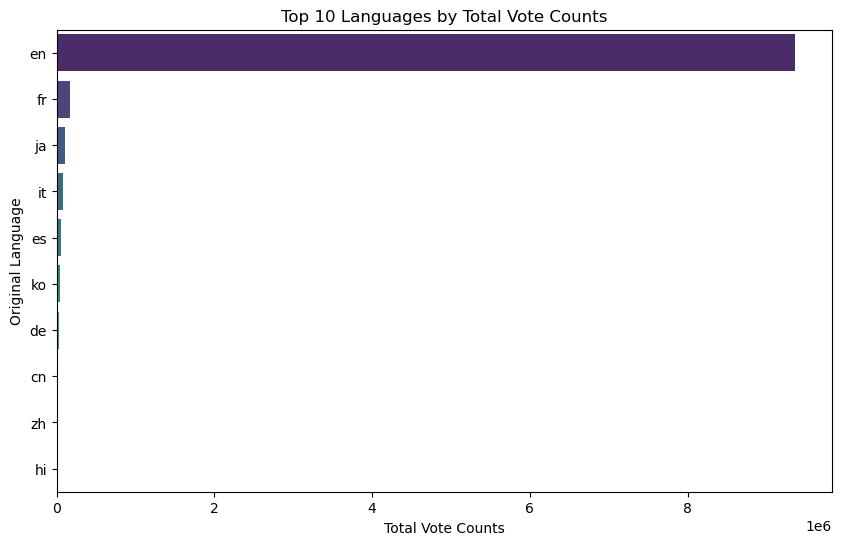

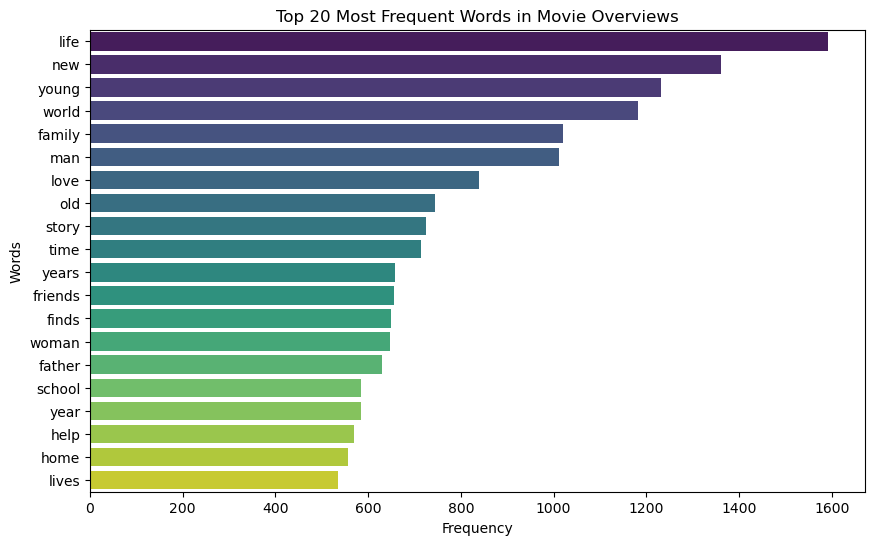

In [15]:
# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt

language_popularity = data_cleaned.groupby('original_language')['vote_count'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,6))
sns.barplot(x=language_popularity.values, y=language_popularity.index, palette='viridis')
plt.title('Top 10 Languages by Total Vote Counts')
plt.xlabel('Total Vote Counts')
plt.ylabel('Original Language')
plt.show()

from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(stop_words='english', max_features=20)
overview_matrix = vectorizer.fit_transform(data_cleaned['overview'])
frequent_words = vectorizer.get_feature_names_out()

word_counts = overview_matrix.sum(axis=0)
word_counts = zip(frequent_words, word_counts.tolist()[0])

word_freq_df = pd.DataFrame(word_counts, columns=['Word', 'Frequency']).sort_values(by='Frequency', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='Frequency', y='Word', data=word_freq_df, palette='viridis')
plt.title('Top 20 Most Frequent Words in Movie Overviews')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.show()

# Insights from the Visualizations
1. Top Languages by Total Vote Counts:
<ol>English is the most popular language in terms of total vote counts</ol>
2. Most Frequent Words in Overview:
<ol>Words like 'life', 'young', 'family' and 'world' are among the most frequently mentioned.</ol>

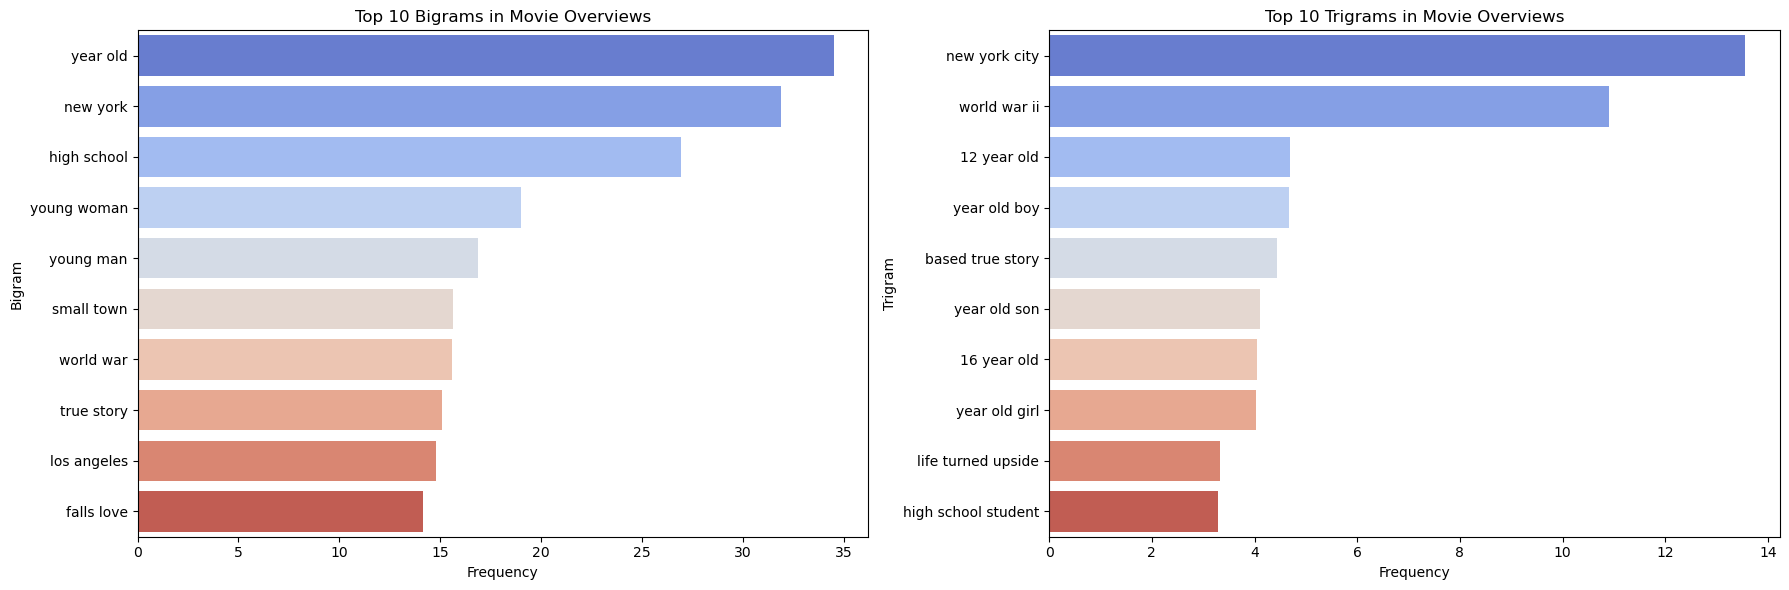

count    9659.000000
mean        0.040196
std         0.223091
min        -1.000000
25%        -0.073942
50%         0.031250
75%         0.166667
max         1.000000
Name: sentiment, dtype: float64

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob

def get_top_ngrams(corpus, n=None):
    vec = TfidfVectorizer(ngram_range=(n,n), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:10]

top_bigrams = get_top_ngrams(data_cleaned['overview'], n=2)
top_trigrams = get_top_ngrams(data_cleaned['overview'], n=3)

# Sentiment Analysis
def get_sentiment(text):
    return TextBlob(text).sentiment.polarity
data_cleaned['sentiment'] = data_cleaned['overview'].apply(get_sentiment)

bigrams_df = pd.DataFrame(top_bigrams, columns=['Bigram', 'Frequency'])
trigrams_df = pd.DataFrame(top_trigrams, columns=['Trigram', 'Frequency'])

fig, ax = plt.subplots(1,2,figsize=(18,6))
sns.barplot(x='Frequency', y='Bigram', data=bigrams_df, ax=ax[0], palette='coolwarm')
ax[0].set_title('Top 10 Bigrams in Movie Overviews')
sns.barplot(x='Frequency', y='Trigram', data=trigrams_df, ax=ax[1], palette='coolwarm')
ax[1].set_title('Top 10 Trigrams in Movie Overviews')
plt.tight_layout()
plt.show()

sentiment_distribution = data_cleaned['sentiment'].describe()
sentiment_distribution

# Text Analysis Results
1. Common Bigrams and Trigrams:
<ol>'young man', 'high school', or 'new york city'. These phrase give us an insight into common settings or character dynamics in movies</ol>
2. Sentiment Analysis:
<ol>The average sentiment across all movies overviews is sligthly postive at approximately 0.04, indicating a generally neutral to slightly positive tone in movie description.</ol>

In [20]:
vote_average_high_threshold = data_cleaned['vote_average'].quantile(0.75)
vote_count_low_threshold = data_cleaned['vote_count'].quantile(0.25)

highly_rated_less_popular_movies = data_cleaned[
    (data_cleaned['vote_average'] >= vote_average_high_threshold) &
    (data_cleaned['vote_count'] <= vote_count_low_threshold)
]

overview_highly_rated_less_popular = highly_rated_less_popular_movies.describe(include='all')
overview_highly_rated_less_popular, highly_rated_less_popular_movies.head()

(           title                                           overview  \
 count        497                                                497   
 unique       497                                                497   
 top     F#*@BOIS  Ace, 23, and Miko, 17, desperately want to bec...   
 freq           1                                                  1   
 mean         NaN                                                NaN   
 std          NaN                                                NaN   
 min          NaN                                                NaN   
 25%          NaN                                                NaN   
 50%          NaN                                                NaN   
 75%          NaN                                                NaN   
 max          NaN                                                NaN   
 
        original_language  vote_count  vote_average   sentiment  
 count                497  497.000000    497.000000  497.000000  
 u

C:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


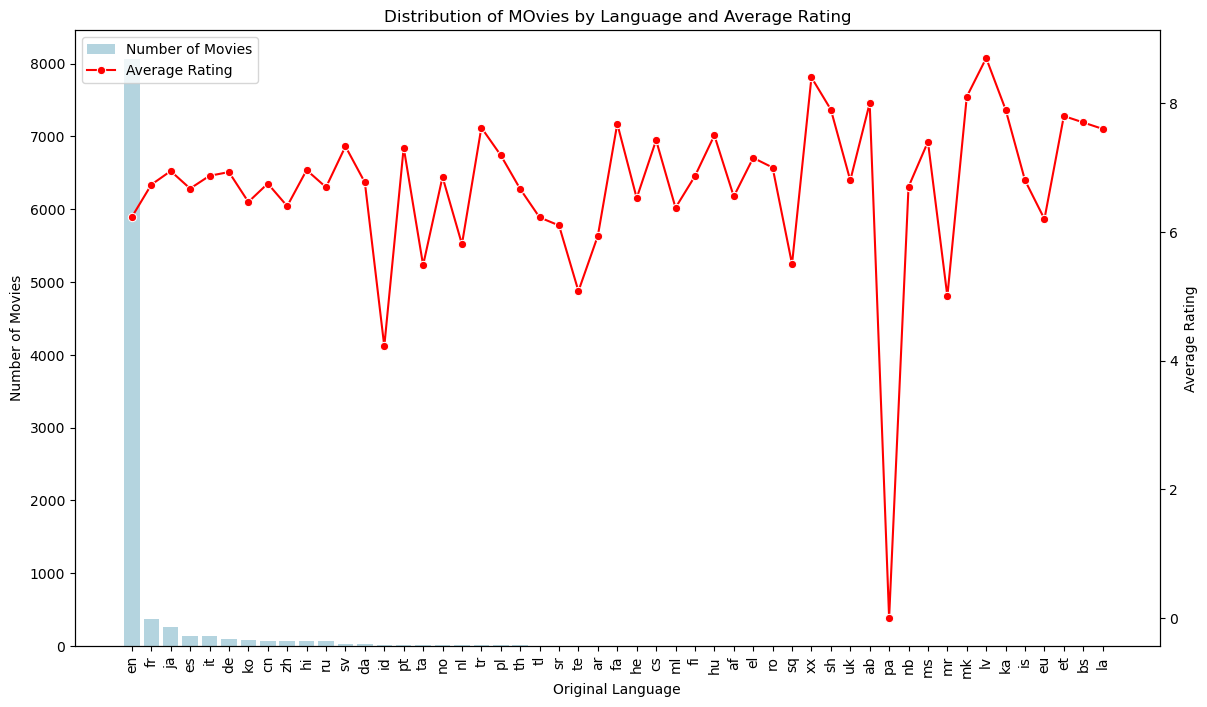

In [23]:
langauge_rating_distribution = data_cleaned.groupby('original_language').agg({
    'vote_average': 'mean',
    'title': 'count'
}).reset_index()

langauge_rating_distribution.sort_values('title', ascending=False, inplace=True)

fig, ax1 = plt.subplots(figsize=(14,8))

sns.barplot(x='original_language', y='title', data=langauge_rating_distribution, ax=ax1, color='lightblue', label='Number of Movies')
ax1.set_xlabel('Original Language')
ax1.set_ylabel('Number of Movies')
ax1.tick_params(axis='x', rotation=90)

ax2 = ax1.twinx()
sns.lineplot(x='original_language', y='vote_average', data=langauge_rating_distribution, ax=ax2, color='red', marker='o', label='Average Rating')
ax2.set_ylabel('Average Rating')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)

plt.title('Distribution of MOvies by Language and Average Rating')
plt.show()

# Distribution of Movies by Language and Average Rating
The visualization illustrates the distribution of movies across different languages and their respective average ratings.

In [13]:
# Relationship between vote average and its frequency
vote_average_freq = data_cleaned['vote_average'].value_counts().reset_index()
vote_average_freq.columns = ['vote_average', 'frequency']

correlation = vote_average_freq.corr()
correlation

,vote_average,frequency
vote_average,1.00000,0.24821
frequency,0.24821,1.00000


The correlation coefficient between the vote average and its frequency in the dataset is approximately 0.248.
<p>This value indicates a weak positive correlation.</p>
<p>This suggests that there is a slight tendency for certain vote averages to occur more frequently than others, but the relationship isn't strong.</p>